In [1]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import get_window

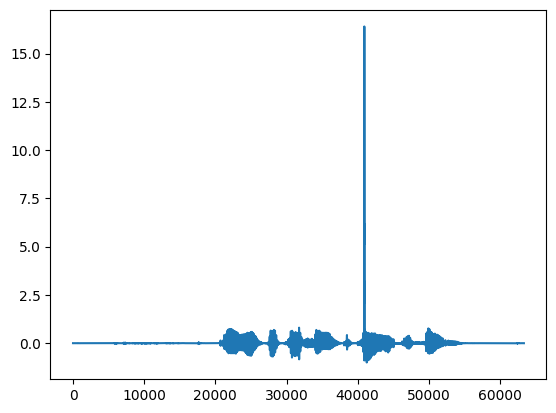

In [2]:
with open('original.flac', 'rb') as f:
    data, samplerate = sf.read(f)

plt.plot(data)

In [3]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

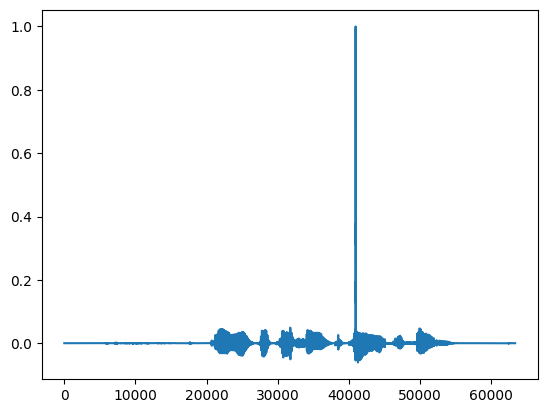

In [4]:
normalized_data = normalize_audio(data)
plt.plot(normalized_data)


In [5]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    print(frame_num)
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [6]:
hop_size = 15 #ms
FFT_size = 2048

audio_framed = frame_audio(data, FFT_size=FFT_size, hop_size=hop_size, sample_rate=samplerate)
print("Framed audio shape: {0}".format(audio_framed.shape))

audio_framed[-1]

265
Framed audio shape: (265, 2048)


array([0.00085449, 0.00085449, 0.00091553, ..., 0.00085449, 0.00085449,
       0.00094604])

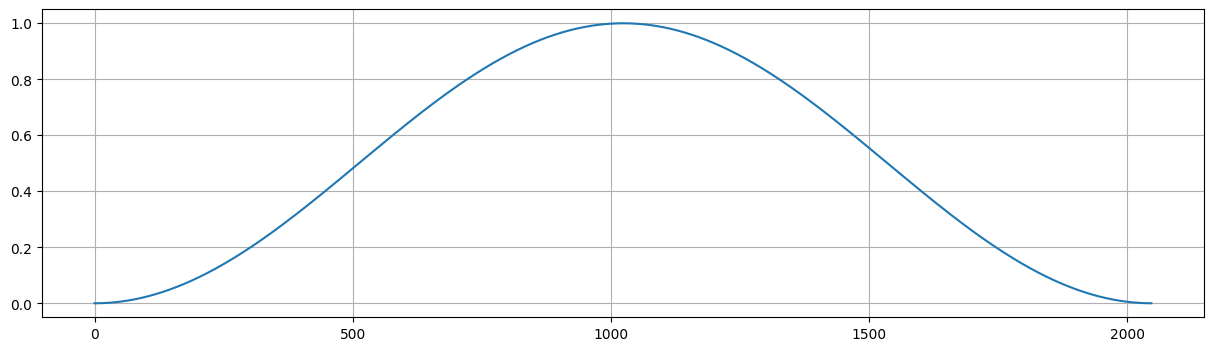

In [7]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)
# plt.plot(audio_framed[0])
# audio_framed[0].shape

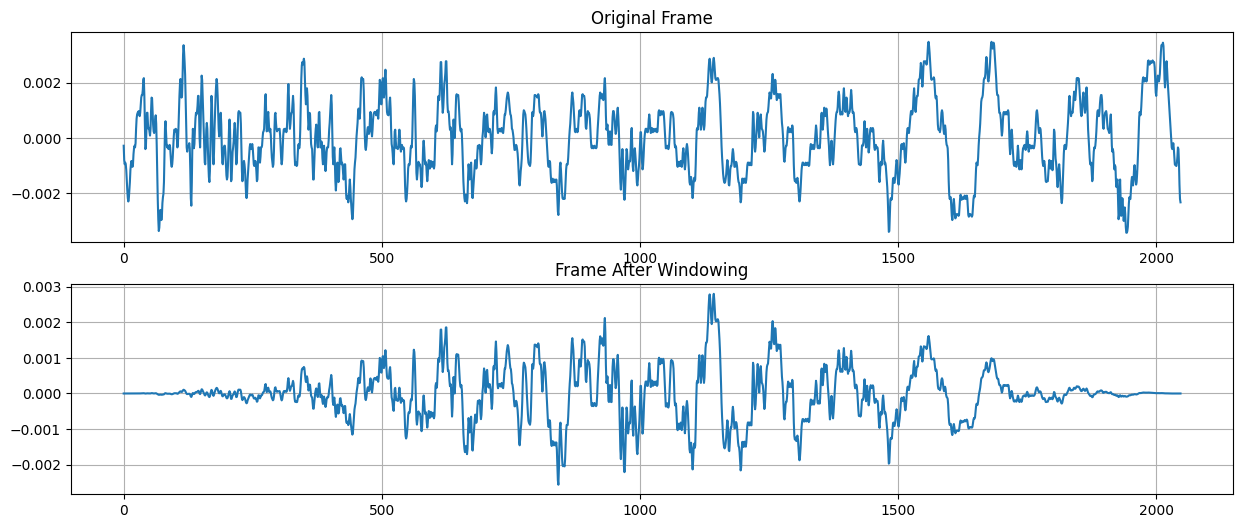

In [8]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

(265, 2048)


c:\Users\Praveen\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


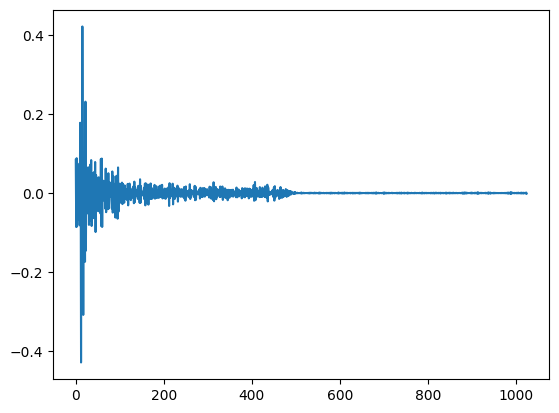

In [9]:
print(audio_win.shape)
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = np.fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

plt.plot(audio_fft[0])


In [10]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(265, 1025)


In [11]:
freq_min = 0
freq_high = samplerate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 8000.0


In [12]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [13]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [14]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, samplerate)
filter_points

MEL min: 0.0
MEL max: 2840.023046708319


array([   0,   23,   52,   88,  134,  192,  264,  355,  470,  614,  796,
       1024])

In [15]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

(10, 1025)


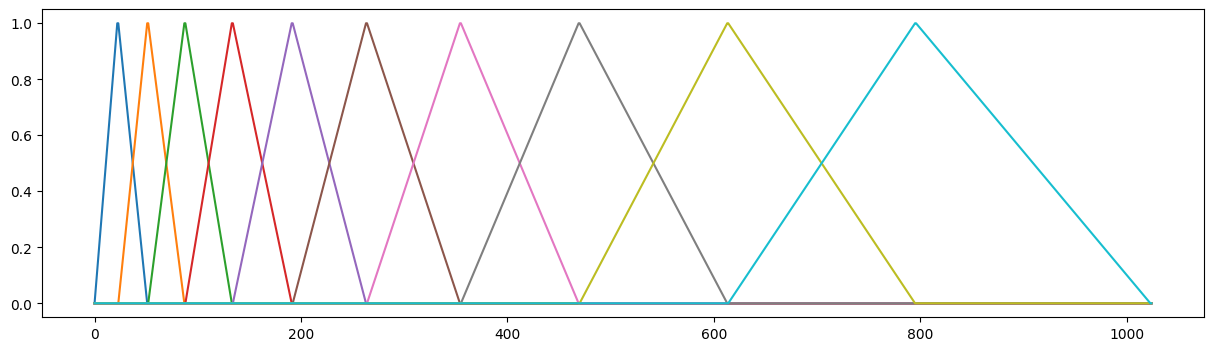

In [16]:
filters = get_filters(filter_points, FFT_size)
print(filters.shape)
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])
# plt.plot(filters[9])

In [17]:
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

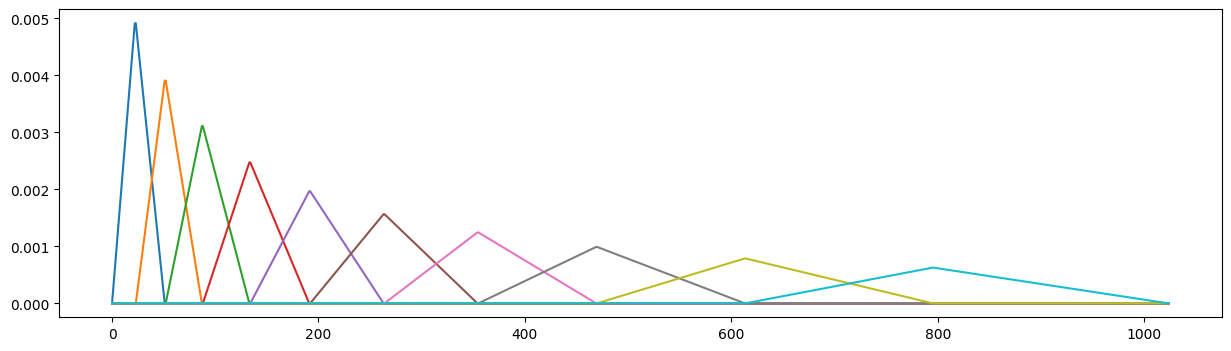

In [18]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [19]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(10, 265)

In [20]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [21]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(40, 265)

In [22]:
cepstral_coefficents.shape

(40, 265)

In [23]:
cepstral_coefficents

array([[-152.65529683, -153.21616713, -154.74468343, ..., -141.53902942,
        -144.70740007, -146.41926571],
       [  41.02350272,   41.11744037,   40.8115576 , ...,   40.66589115,
          37.3818659 ,   35.61070568],
       [  -5.26196564,   -4.65211891,   -3.69500815, ...,   -7.5583603 ,
          -3.87804683,   -2.64711928],
       ...,
       [  14.14290534,   14.81619443,   16.05573637, ...,   12.70742456,
          12.70933329,   13.0897204 ],
       [  -5.26196564,   -4.65211891,   -3.69500815, ...,   -7.5583603 ,
          -3.87804683,   -2.64711928],
       [  41.02350272,   41.11744037,   40.8115576 , ...,   40.66589115,
          37.3818659 ,   35.61070568]])